# Failure Landscape Notebook (B-v2)

목적: **Failure Landscape 관찰**

1. **Stage 분포** (GEN / PATCH / EXEC)
2. **Stage × error_type**
3. **Stage × 비용** (`gen_elapsed_sec`, `elapsed_sec`)
4. **Stage × patch size** (`files_changed`, `patch_lines_added`, `patch_lines_removed`)


In [1]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

PROJECT_ROOT = Path('..').resolve()  # notebooks/ 아래에 둘 경우를 가정
RUNS_DIR = PROJECT_ROOT / 'runs'

def find_latest_results_csv(runs_dir: Path) -> Path:
    cands = sorted(runs_dir.glob('*/results.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
    if not cands:
        raise FileNotFoundError(f'No results.csv found under: {runs_dir}')
    return cands[0]

results_csv = find_latest_results_csv(RUNS_DIR)
results_csv

PosixPath('/home/dibaeck/workspace/project_IR_sLM_MAS/runs/exp1_init_qwen2p5_baseline_20260213_060256/results.csv')

In [2]:
# results_csv = Path('../runs/exp1_xxx_YYYYMMDD_HHMMSS/results.csv').resolve()

df = pd.read_csv(results_csv)
df.head()

,task_id,trial_id,model,prompt_hash,taxonomy_version,success,stage,error_type,signature,returncode,gen_elapsed_sec,elapsed_sec,context_used,context_num_files,repo_context_preview,format_used,format_ok,format_reason,patch_lines_added,patch_lines_removed,files_changed,timestamp,seed
0,astropy__astropy-12907,0,Qwen/Qwen2.5-Coder-7B-Instruct,1d006f36813d2fc095bc8da160e7e87abfd8d05ee8957d...,B-v2-step2-2,False,PATCH,PATCH_FAIL,git_apply_corrupt_patch,128.0,3.310239,0.563434,True,80,Existing files (choose from these):\nsetup.py\...,False,False,NaN,17,0,1,2026-02-13T06:02:56.399945,42
1,astropy__astropy-14182,0,Qwen/Qwen2.5-Coder-7B-Instruct,323a3b727d26875c53e665ce8dcd10f792793ee5799a7a...,B-v2-step2-2,False,PATCH,PATCH_FAIL,git_apply_corrupt_patch,128.0,4.118518,0.667864,True,80,Existing files (choose from these):\nsetup.py\...,False,False,NaN,10,0,1,2026-02-13T06:03:00.274105,42
2,astropy__astropy-14365,0,Qwen/Qwen2.5-Coder-7B-Instruct,232a841813d672f784b09b1e96ec3c80e68dec2004a896...,B-v2-step2-2,False,PATCH,PATCH_FAIL,git_apply_corrupt_patch,128.0,1.570795,0.536546,True,80,Existing files (choose from these):\nsetup.py\...,False,False,NaN,1,1,1,2026-02-13T06:03:05.061165,42
3,astropy__astropy-14995,0,Qwen/Qwen2.5-Coder-7B-Instruct,fd14cad64dd3edbd82b7592d7f25cd7092f88230923805...,B-v2-step2-2,False,PATCH,PATCH_FAIL,git_apply_corrupt_patch,128.0,3.418180,0.607798,True,80,Existing files (choose from these):\nsetup.py\...,False,False,NaN,3,3,1,2026-02-13T06:03:07.169109,42
4,astropy__astropy-6938,0,Qwen/Qwen2.5-Coder-7B-Instruct,c5b32e42610f8f080a47c68fd74b8756f9c425cccd00e2...,B-v2-step2-2,False,PATCH,PATCH_FAIL,git_apply_corrupt_patch,128.0,1.768654,0.637208,True,80,Existing files (choose from these):\nsetup.py\...,False,False,NaN,1,1,1,2026-02-13T06:03:11.195625,42


In [3]:
# 안전한 정규화
if "context_used" in df.columns:
    if df["context_used"].dtype == object:
        s = df["context_used"].astype(str).str.strip().str.lower()
        df["context_used"] = s.isin(["1","true","t","yes","y"])
else:
    df["context_used"] = False

if "context_num_files" in df.columns:
    df["context_num_files"] = pd.to_numeric(df["context_num_files"], errors="coerce").fillna(0)
else:
    df["context_num_files"] = 0

total = len(df)
used = df["context_used"].sum()
used_ratio = used / total if total > 0 else 0

summary = {
    "total_tasks": total,
    "context_used_count": int(used),
    "context_used_ratio": round(used_ratio, 4),
    "context_num_files_mean": round(df["context_num_files"].mean(), 2),
    "context_num_files_median": float(df["context_num_files"].median()),
    "context_num_files_max": int(df["context_num_files"].max()),
}

pd.Series(summary)

total_tasks                 200.00
context_used_count          200.00
context_used_ratio            1.00
context_num_files_mean       79.96
context_num_files_median     80.00
context_num_files_max        80.00
dtype: float64

In [4]:
# --- Basic normalization / cleaning ---

# 수정 : 직접 mapping
ET_TO_STAGE = {
    "PASS": "DONE",
    "GEN_FAIL": "GEN",
    "REPO_FAIL": "REPO",
    "PATCH_FAIL": "PATCH",
    "TIMEOUT": "EXEC",
    "EXEC_FAIL": "EXEC",
    "TEST_FAIL": "TEST",
    "OTHER_RUNTIME": "EXEC",  # B-v2: fallback을 EXEC로 흡수(원하면 UNKNOWN으로 둬도 됨)
}

# stage 정규화 + fallback
df['stage'] = df.get('stage', '').fillna('').astype(str).str.upper().str.strip()
df['error_type'] = df.get('error_type', '').fillna('').astype(str).str.upper().str.strip()

missing_stage = (df['stage'] == '') | (df['stage'] == 'UNKNOWN')
df.loc[missing_stage, 'stage'] = df.loc[missing_stage, 'error_type'].map(ET_TO_STAGE).fillna('UNKNOWN')

# 숫자 컬럼들 안전하게 변환
num_cols = [c for c in ['gen_elapsed_sec','elapsed_sec','patch_lines_added','patch_lines_removed','files_changed','returncode'] if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# stage 표준화 (대문자)
if 'stage' in df.columns:
    df['stage'] = df['stage'].astype(str).str.upper().str.strip()

# 수정 완료
if 'success' in df.columns:
    if df['success'].dtype == object:
        s = df['success'].astype(str).str.strip().str.lower()
        df['success'] = s.isin(['1','true','t','yes','y'])

df.shape, df.columns

((200, 23),
 Index(['task_id', 'trial_id', 'model', 'prompt_hash', 'taxonomy_version', 'success', 'stage', 'error_type', 'signature', 'returncode', 'gen_elapsed_sec',
        'elapsed_sec', 'context_used', 'context_num_files', 'repo_context_preview', 'format_used', 'format_ok', 'format_reason', 'patch_lines_added',
        'patch_lines_removed', 'files_changed', 'timestamp', 'seed'],
       dtype='object'))

## 1) Stage 분포

In [5]:
stage_order = ['GEN','REPO','PATCH','EXEC','TEST','DONE','UNKNOWN']

if 'stage' not in df.columns:
    raise ValueError('stage column not found in results.csv')

stage_counts = df['stage'].value_counts(dropna=False)
stage_frac = (stage_counts / len(df)).rename('ratio')
stage_summary = pd.concat([stage_counts.rename('count'), stage_frac], axis=1)

stage_summary = stage_summary.reindex(stage_order).dropna(how='all')
stage_summary

,count,ratio
stage,,
GEN,10.0,0.05
PATCH,190.0,0.95


In [6]:
df[['stage','error_type','signature']].value_counts().head(20)

stage  error_type  signature              
PATCH  PATCH_FAIL  git_apply_corrupt_patch    183
GEN    GEN_FAIL    llm_call_fail                9
PATCH  PATCH_FAIL  git_apply_hunk_failed        4
                   git_apply_path_missing       3
GEN    GEN_FAIL    invalid_diff_format          1
Name: count, dtype: int64

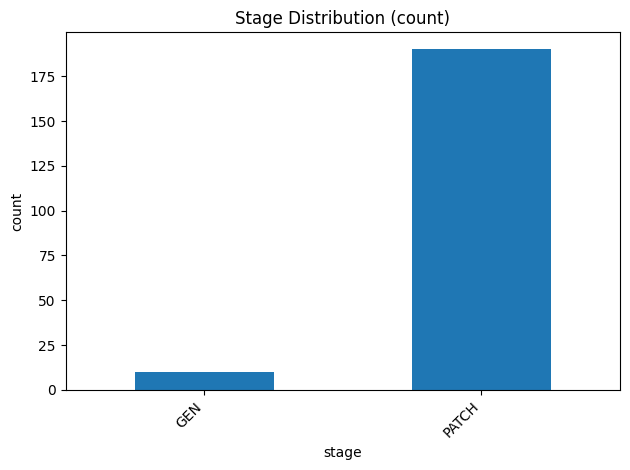

In [7]:
plt.figure()
stage_counts.loc[[s for s in stage_order if s in stage_counts.index] + [s for s in stage_counts.index if s not in stage_order]].plot(kind='bar')
plt.title('Stage Distribution (count)')
plt.xlabel('stage')
plt.ylabel('count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2) Stage × error_type

In [8]:
# stage / error_type 빈값 방지 (혹시 이전 셀 누락 대비)
df['stage'] = df.get('stage', '').fillna('').astype(str).str.upper().str.strip().replace({'': 'UNKNOWN'})
df['error_type'] = df.get('error_type', '').fillna('').astype(str).str.upper().str.strip().replace({'': 'UNKNOWN'})

# Count table
ct = pd.crosstab(df['stage'], df['error_type'])

# Row-wise ratio (%) : 각 stage 내부에서 error_type 비율
rt = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0) * 100

# 보기 좋게 합치기: "count (xx.x%)"
combined = ct.astype(int).astype(str) + " (" + rt.round(1).astype(str) + "%)"

# stage 순서 정렬 (stage_order 있으면 활용)
try:
    combined = combined.reindex(stage_order).dropna(how='all')
    ct = ct.reindex(stage_order).dropna(how='all')
    rt = rt.reindex(stage_order).dropna(how='all')
except Exception:
    pass

display(pd.DataFrame({
    "rows": [len(df)],
}, index=["meta"]))

,rows
meta,200


In [9]:
print("=== Stage × error_type (count) ===")
display(ct)

print("=== Stage × error_type (row-wise %) ===")
display(rt.round(2))

print("=== Stage × error_type (count + %) ===")
display(combined)

=== Stage × error_type (count) ===


error_type,GEN_FAIL,PATCH_FAIL
stage,,
GEN,10.0,0.0
PATCH,0.0,190.0


=== Stage × error_type (row-wise %) ===


error_type,GEN_FAIL,PATCH_FAIL
stage,,
GEN,100.0,0.0
PATCH,0.0,100.0


=== Stage × error_type (count + %) ===


error_type,GEN_FAIL,PATCH_FAIL
stage,,
GEN,10 (100.0%),0 (0.0%)
PATCH,0 (0.0%),190 (100.0%)


## 3) Stage × 비용

- `gen_elapsed_sec` 평균
- `elapsed_sec` 평균


In [10]:
# 숫자 변환 안전 (혹시 이전 셀 누락 대비)
for c in ['gen_elapsed_sec', 'elapsed_sec']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

def _agg_time(g: pd.DataFrame) -> pd.Series:
    out = {}
    for col in ['gen_elapsed_sec', 'elapsed_sec']:
        if col in g.columns:
            x = g[col].dropna()
            out[f"{col}_n"] = int(x.shape[0])
            out[f"{col}_mean"] = float(x.mean()) if len(x) else np.nan
            out[f"{col}_median"] = float(x.median()) if len(x) else np.nan
        else:
            out[f"{col}_n"] = 0
            out[f"{col}_mean"] = np.nan
            out[f"{col}_median"] = np.nan
    return pd.Series(out)

time_by_stage = df.groupby('stage', dropna=False).apply(_agg_time).reset_index()

# stage order 정렬
if 'stage_order' in globals():
    time_by_stage['stage'] = pd.Categorical(time_by_stage['stage'], categories=stage_order, ordered=True)
    time_by_stage = time_by_stage.sort_values('stage')

# 보기 좋게 라운딩
for c in time_by_stage.columns:
    if c.endswith('_mean') or c.endswith('_median'):
        time_by_stage[c] = time_by_stage[c].round(4)

print("=== Stage × 비용 요약 ===")
display(time_by_stage)

=== Stage × 비용 요약 ===


,stage,gen_elapsed_sec_n,gen_elapsed_sec_mean,gen_elapsed_sec_median,elapsed_sec_n,elapsed_sec_mean,elapsed_sec_median
0,GEN,10.0,1.1398,0.0203,10.0,1.1398,0.0203
1,PATCH,190.0,2.4484,1.8730,190.0,0.5392,0.5151


## 4) Stage × patch size

- `files_changed`
- `patch_lines_added / removed`


In [11]:
# 숫자 변환 안전
for c in ['files_changed', 'patch_lines_added', 'patch_lines_removed']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

def _agg_patch(g: pd.DataFrame) -> pd.Series:
    out = {}
    cols = ['files_changed', 'patch_lines_added', 'patch_lines_removed']
    for col in cols:
        if col in g.columns:
            x = g[col].dropna()
            out[f"{col}_n"] = int(x.shape[0])
            out[f"{col}_mean"] = float(x.mean()) if len(x) else np.nan
            out[f"{col}_median"] = float(x.median()) if len(x) else np.nan
        else:
            out[f"{col}_n"] = 0
            out[f"{col}_mean"] = np.nan
            out[f"{col}_median"] = np.nan

    # patch "size" 보조 지표(선택): added+removed
    if 'patch_lines_added' in g.columns and 'patch_lines_removed' in g.columns:
        size = (pd.to_numeric(g['patch_lines_added'], errors='coerce').fillna(0) +
                pd.to_numeric(g['patch_lines_removed'], errors='coerce').fillna(0))
        out["patch_total_lines_mean"] = float(size.mean())
        out["patch_total_lines_median"] = float(size.median())
    else:
        out["patch_total_lines_mean"] = np.nan
        out["patch_total_lines_median"] = np.nan

    return pd.Series(out)

patch_by_stage = df.groupby('stage', dropna=False).apply(_agg_patch).reset_index()

# stage order 정렬
if 'stage_order' in globals():
    patch_by_stage['stage'] = pd.Categorical(patch_by_stage['stage'], categories=stage_order, ordered=True)
    patch_by_stage = patch_by_stage.sort_values('stage')

# 라운딩
for c in patch_by_stage.columns:
    if c.endswith('_mean') or c.endswith('_median'):
        patch_by_stage[c] = patch_by_stage[c].round(4)

print("=== Stage × patch size 요약 ===")
display(patch_by_stage)

=== Stage × patch size 요약 ===


,stage,files_changed_n,files_changed_mean,files_changed_median,patch_lines_added_n,patch_lines_added_mean,patch_lines_added_median,patch_lines_removed_n,patch_lines_removed_mean,patch_lines_removed_median,patch_total_lines_mean,patch_total_lines_median
0,GEN,10.0,0.0000,0.0,10.0,0.0000,0.0,10.0,0.0000,0.0,0.0000,0.0
1,PATCH,190.0,1.1684,1.0,190.0,3.3526,2.0,190.0,0.9842,1.0,4.3368,3.0


## (옵션) Stage별 핵심 요약 테이블 저장

`runs/.../stage_landscape_summary.csv`로 저장

In [12]:
# out_dir = results_csv.parent
# summary_path = out_dir / 'stage_landscape_summary.csv'

# # 요약: stage별 count + 평균 비용 + 평균 patch size
# summary = pd.DataFrame({'count': df.groupby('stage').size()})
# for c in cost_cols:
#     summary[f'mean_{c}'] = df.groupby('stage')[c].mean()
# for c in patch_cols:
#     summary[f'mean_{c}'] = df.groupby('stage')[c].mean()

# summary = summary.sort_values('count', ascending=False)
# summary.to_csv(summary_path, index=True)
# summary_path, summary

# “Step2-1이 진짜 컨텍스트 실험이었는지” 가장 확실한 판정 기준
### (판정 1) results.csv에서 context_used == True 비율
이게 0% 또는 매우 낮으면 → 컨텍스트 실험 아니었음(거의)

### (판정 2) trace에서 repo_context_preview가 “실제 파일 리스트”인지
- 각 trace json에서 preview가 빈 문자열/None이면 → 컨텍스트 미사용
- "Existing files ...\npath1\npath2\n..." 형태로 채워져 있으면 → 컨텍스트가 실제로 프롬프트에 들어간 것

> 판정1,2 둘 다 확인되면 “진짜 컨텍스트 실험”

In [13]:
# 안전한 정규화
if "context_used" in df.columns:
    if df["context_used"].dtype == object:
        s = df["context_used"].astype(str).str.strip().str.lower()
        df["context_used"] = s.isin(["1","true","t","yes","y"])
else:
    df["context_used"] = False

if "context_num_files" in df.columns:
    df["context_num_files"] = pd.to_numeric(df["context_num_files"], errors="coerce").fillna(0)
else:
    df["context_num_files"] = 0

total = len(df)
used = df["context_used"].sum()
used_ratio = used / total if total > 0 else 0

summary = {
    "total_tasks": total,
    "context_used_count": int(used),
    "context_used_ratio": round(used_ratio, 4),
    "context_num_files_mean": round(df["context_num_files"].mean(), 2),
    "context_num_files_median": float(df["context_num_files"].median()),
    "context_num_files_max": int(df["context_num_files"].max()),
}

pd.Series(summary)

total_tasks                 200.00
context_used_count          200.00
context_used_ratio            1.00
context_num_files_mean       79.96
context_num_files_median     80.00
context_num_files_max        80.00
dtype: float64